# Plotting time-series in R using pluto

A getting started guide

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
source("config.R")
source("goofy/plot.common.R")

indices<-Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R


Let's pick a long time-series. This will allow us to play with different aspects of plotting...

In [2]:
cutOff <- Sys.Date() - 10
trIndices <- indices$NseTimeSeries() %>%
    group_by(NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    filter(ST <= '2005-01-01' && ET >= cutOff && NAME %like% '% TR') %>%
    arrange(ST)

trIndices %>% print(n=Inf)

Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# Source:     lazy query [?? x 3]
# Database:   Microsoft SQL Server 13.00.4224[ro1@NORWAY/StockViz]
# Ordered by: ST
   NAME                        ST         ET        
   <chr>                       <date>     <date>    
 1 NIFTY50 EQUAL WEIGHT TR     1995-11-03 2019-06-25
 2 NIFTY 500 TR                1998-11-26 2019-06-25
 3 NIFTY FMCG TR               1998-11-26 2019-06-25
 4 NIFTY MNC TR                1998-11-26 2019-06-25
 5 NIFTY SERVICES SECTOR TR    1999-06-01 2019-06-25
 6 NIFTY 50 TR                 1999-06-30 2019-06-25
 7 NIFTY IT TR                 1999-06-30 2019-06-25
 8 NIFTY BANK TR               2000-01-01 2019-06-25
 9 NIFTY PSE TR                2000-01-03 2019-06-25
10 NIFTY ENERGY TR             2001-01-01 2019-06-25
11 NIFTY PHARMA TR             2001-01-01 2019-06-25
12 NIFTY NEXT 50 TR            2002-11-08 2019-06-25
13 NIFTY MIDCAP 100 TR         2003-01-01 2019-06-25
14 NIFTY 100 TR                2003-01-01 2019-06-25
15 NIFTY100 EQUAL WEIGHT TR    200

NIFTY 500 TR makes a good candidate. It is a broad based index the represents the top-500 stocks by free-float market cap listed on the NSE...

In [3]:
indexName <- "NIFTY 500 TR"
trDf <- data.frame(indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, HIGH, LOW, OPEN, CLOSE))
trXts<-xts(trDf[,-1], trDf[,1])

print(head(trXts))
print(tail(trXts))

           HIGH LOW OPEN  CLOSE
1998-11-26   NA  NA   NA 611.43
1998-11-27   NA  NA   NA 603.22
1998-11-28   NA  NA   NA 602.15
1998-11-30   NA  NA   NA 607.47
1998-12-01   NA  NA   NA 606.23
1998-12-02   NA  NA   NA 609.96
           HIGH LOW OPEN    CLOSE
2019-06-18   NA  NA   NA 14229.85
2019-06-19   NA  NA   NA 14192.79
2019-06-20   NA  NA   NA 14380.25
2019-06-21   NA  NA   NA 14284.21
2019-06-24   NA  NA   NA 14258.15
2019-06-25   NA  NA   NA 14360.63


Note: the series only has closing prices. 

In [4]:
#setup the data for ggplot
firstDate <- first(index(trXts))
lastDate <- last(index(trXts))
xAxisTicks <- seq(from=firstDate, to=lastDate, length.out=10)

toPlotDf <- data.frame(trXts[, 'CLOSE'])
names(toPlotDf) <- c('C')
toPlotDf$T <- index(trXts)

options(repr.plot.width=16, repr.plot.height=8)

### plot the series as-is

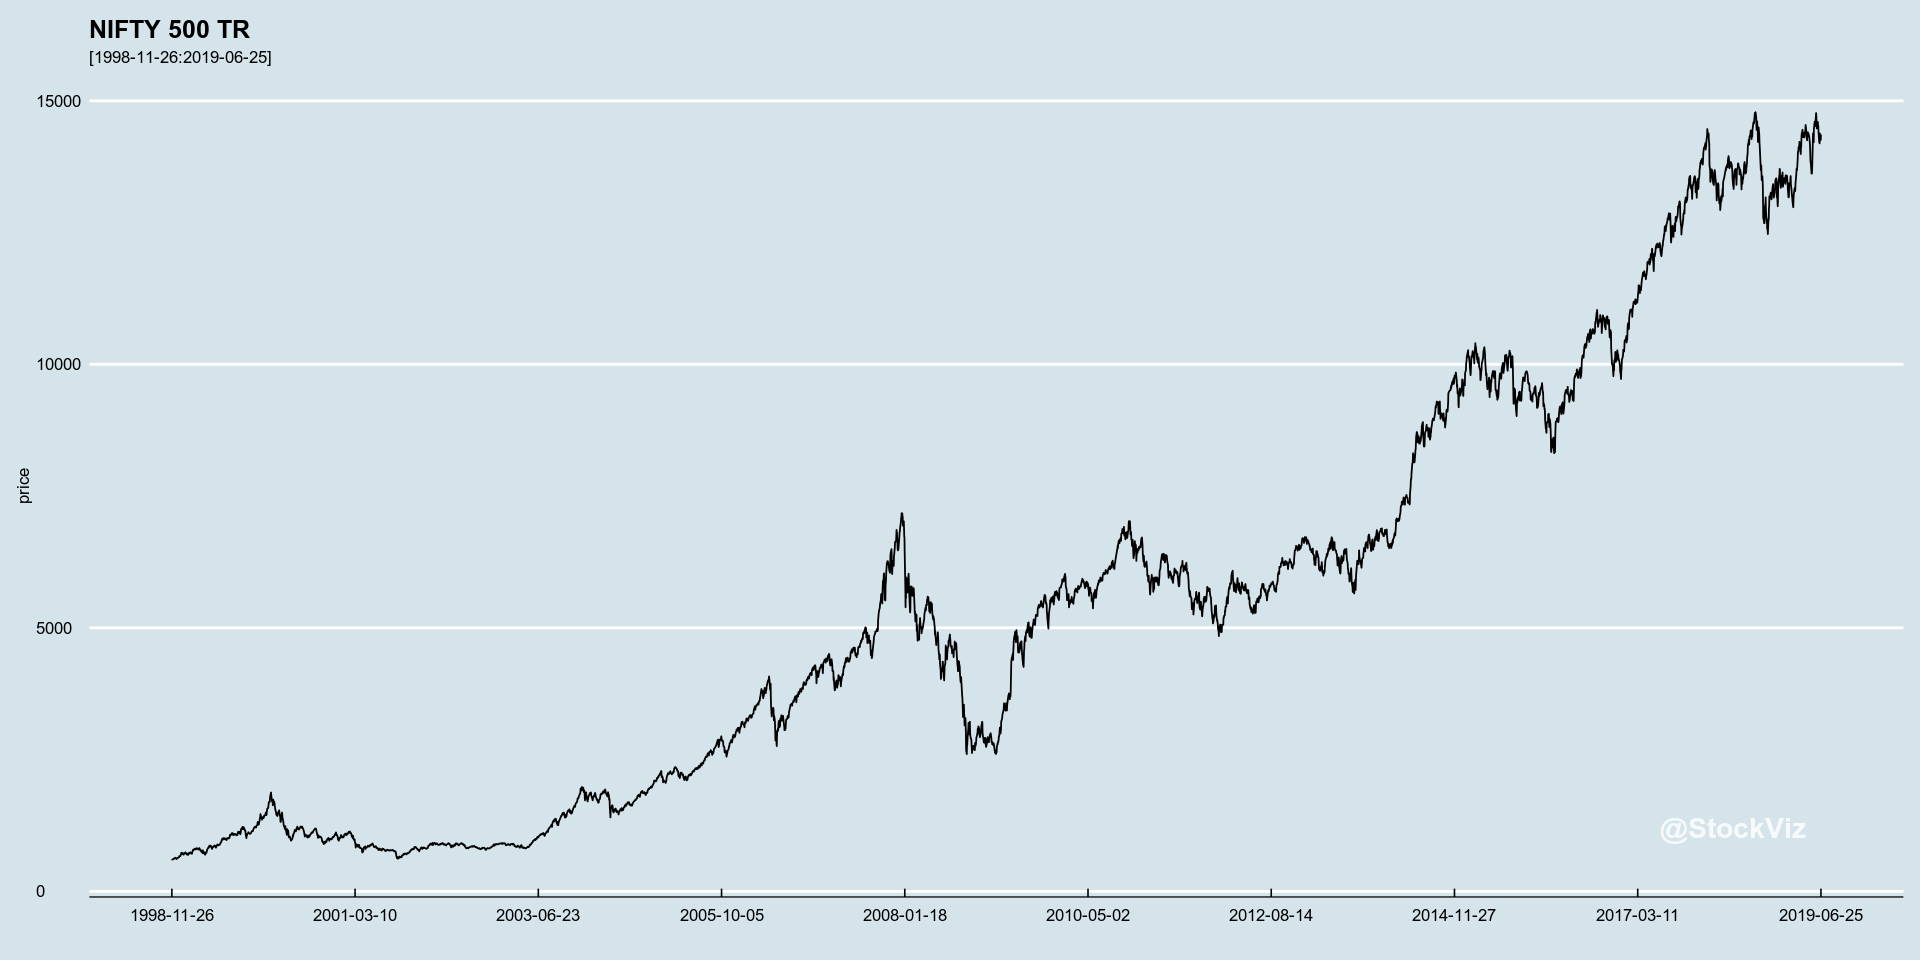

In [5]:
ggplot(toPlotDf, aes(x=T, y=C)) +
    theme_economist() +
    geom_line() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='price', color='', title=sprintf("%s", indexName), subtitle=sprintf("[%s:%s]", firstDate, lastDate)) +
    annotate("text", x=lastDate, y=min(toPlotDf$C, na.rm=T), label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

### plot log-scale

When using a logarithmic scale, the vertical distance between the prices on the scale will be equal when the percent change between the values is the same. Using the above example, the distance between 10 and 15 would be equal to the distance between 20 and 30 because they both represent a price increase of 50%.
[investopedia](https://www.investopedia.com/ask/answers/05/logvslinear.asp)

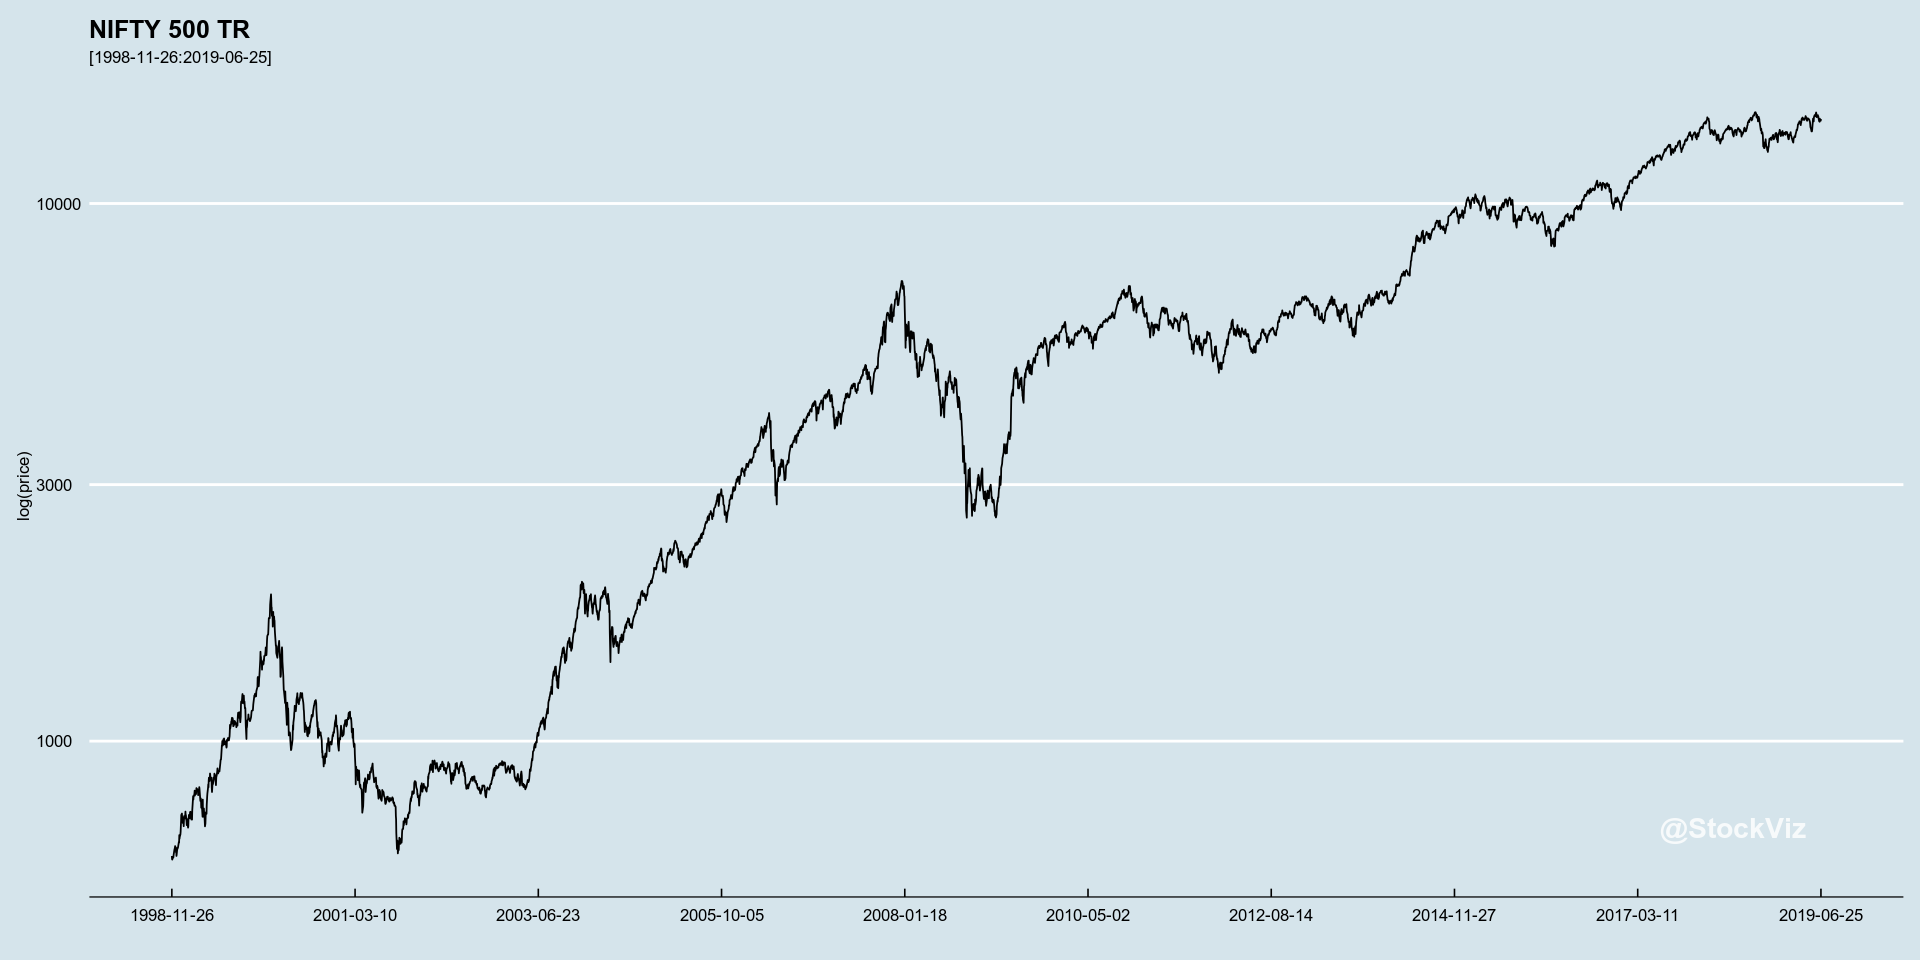

In [6]:
ggplot(toPlotDf, aes(x=T, y=C)) +
    theme_economist() +
    geom_line() +
    scale_y_log10() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='log(price)', color='', title=sprintf("%s", indexName), subtitle=sprintf("[%s:%s]", firstDate, lastDate)) +
    annotate("text", x=lastDate, y=min(toPlotDf$C, na.rm=T), label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

### plot monthly candlestick chart

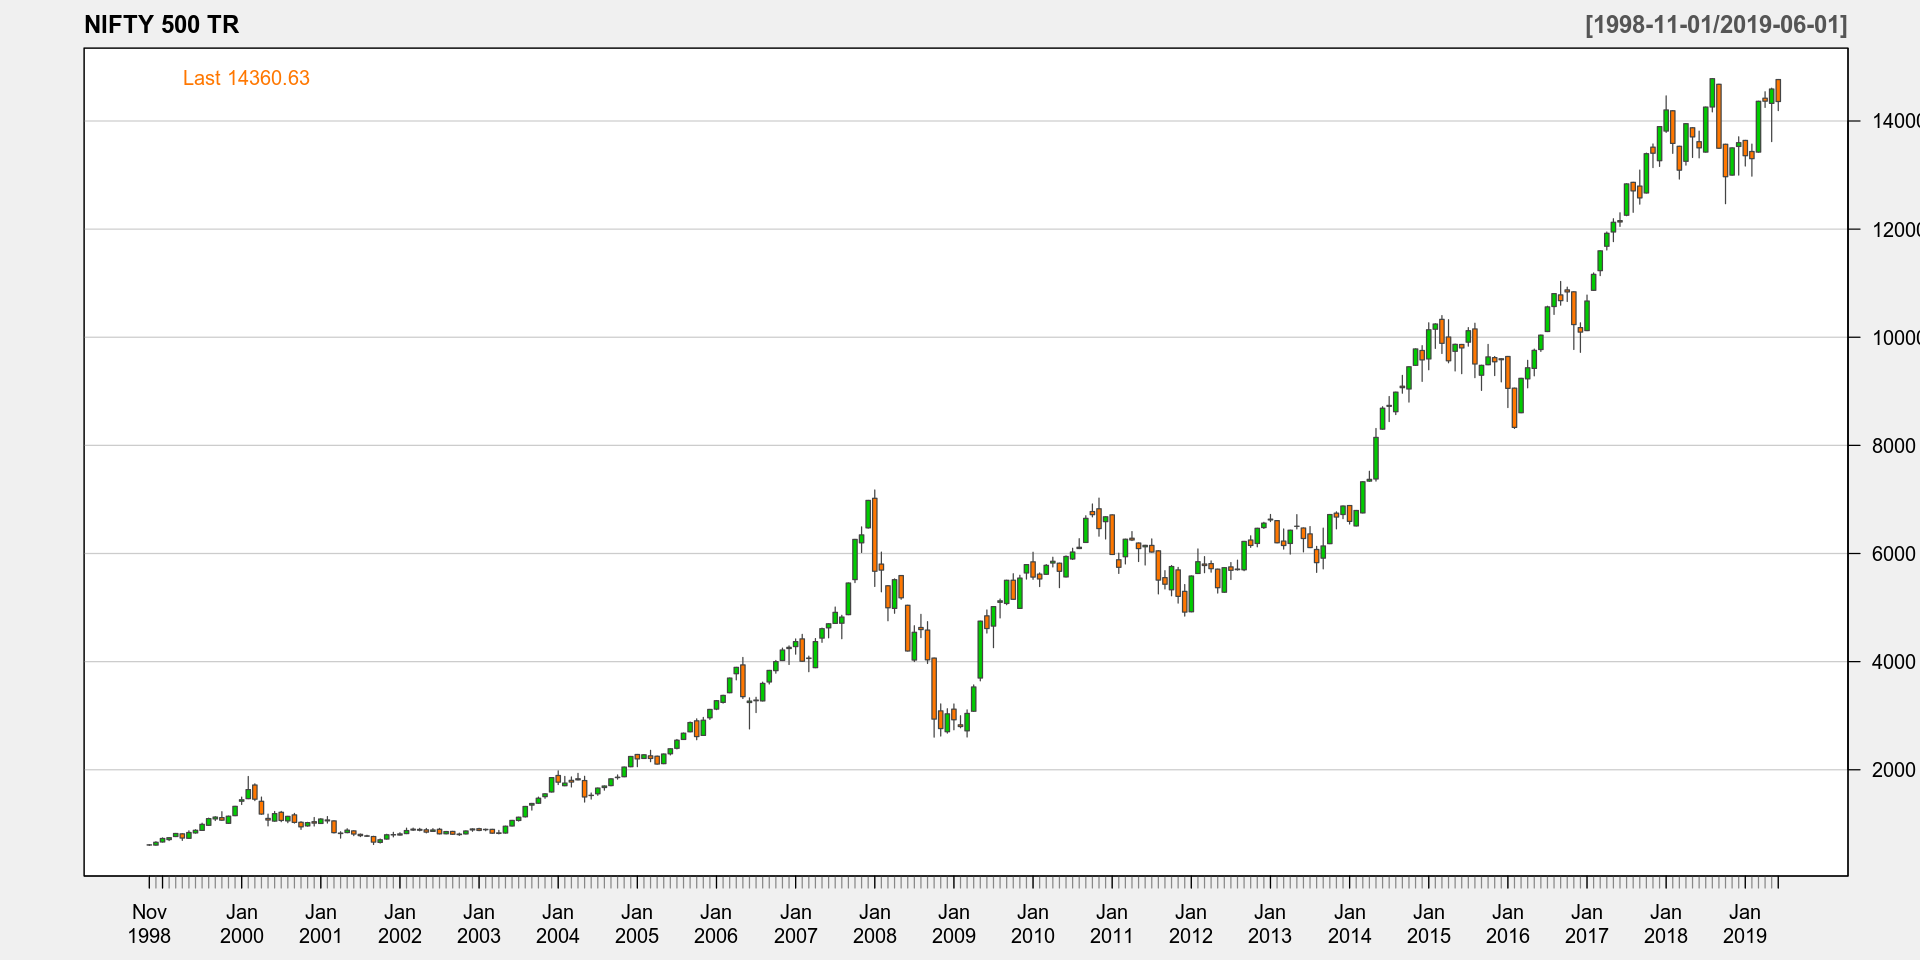

In [7]:
monthlyTr <- to.monthly(trXts$CLOSE)
names(monthlyTr) <- c('Open', 'High', 'Low', 'Close')

chartSeries(monthlyTr, theme = 'white', name = indexName)

#### add some chart studies...

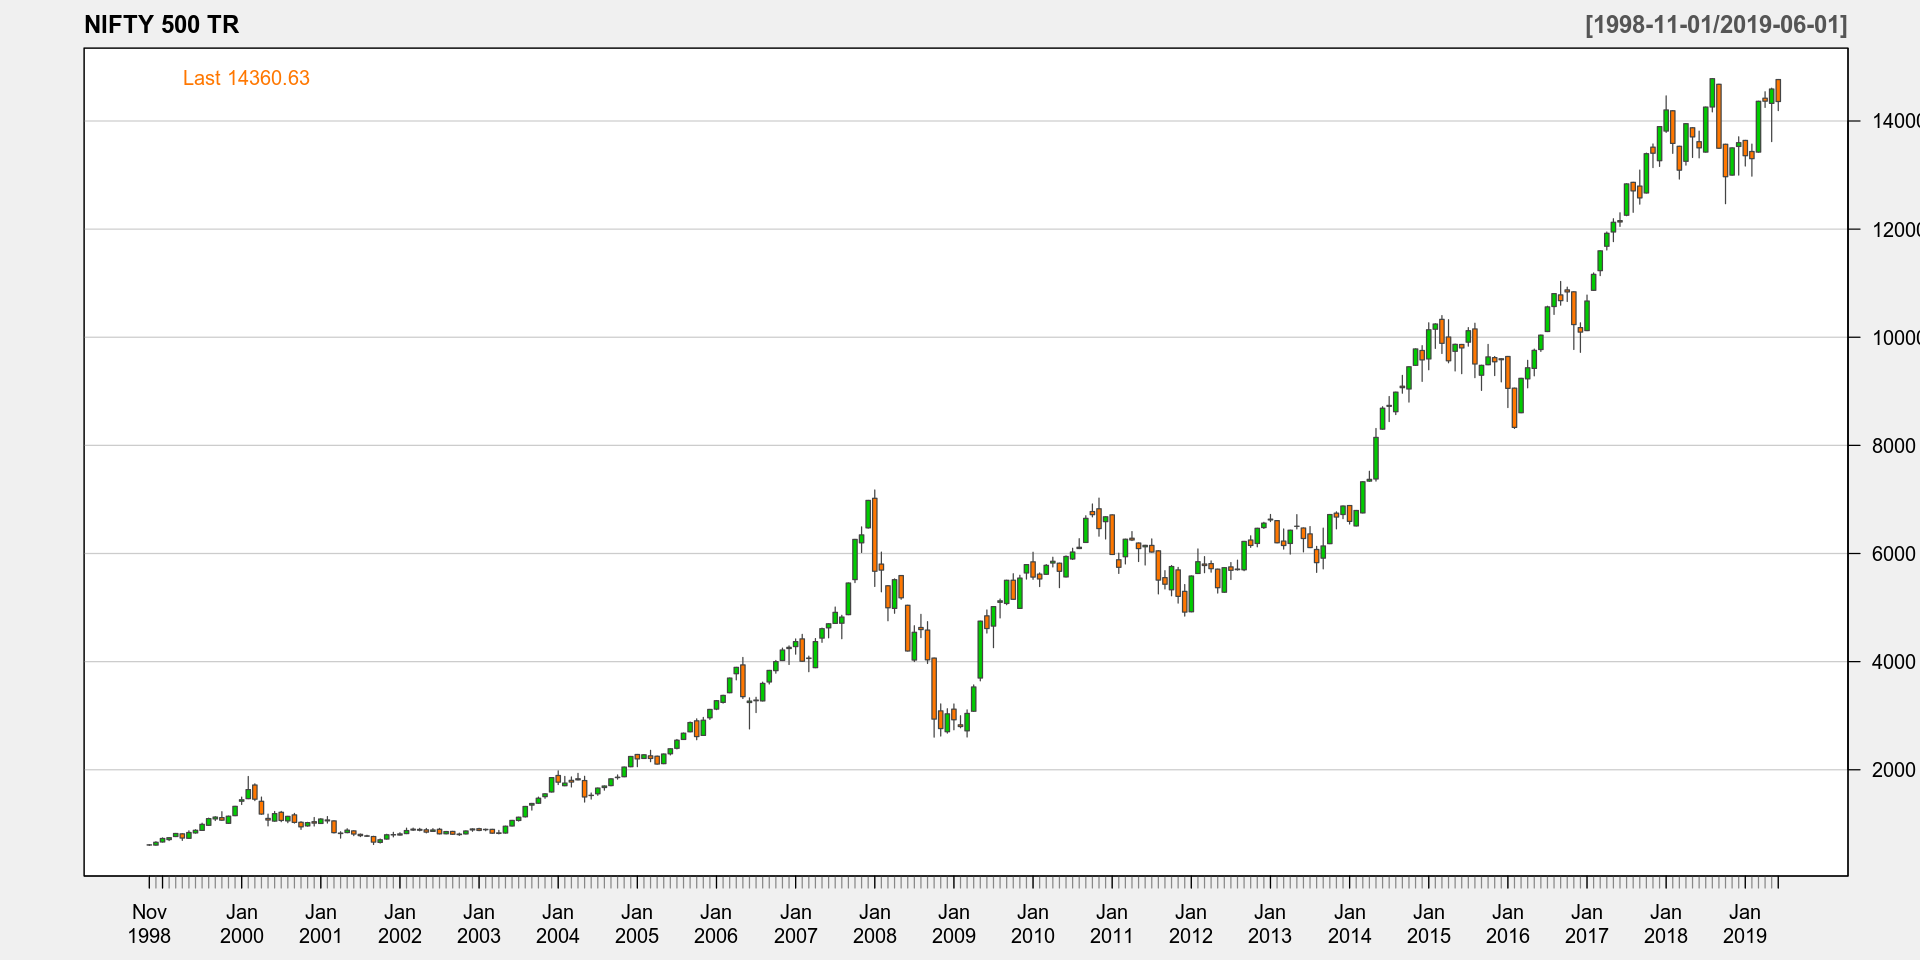

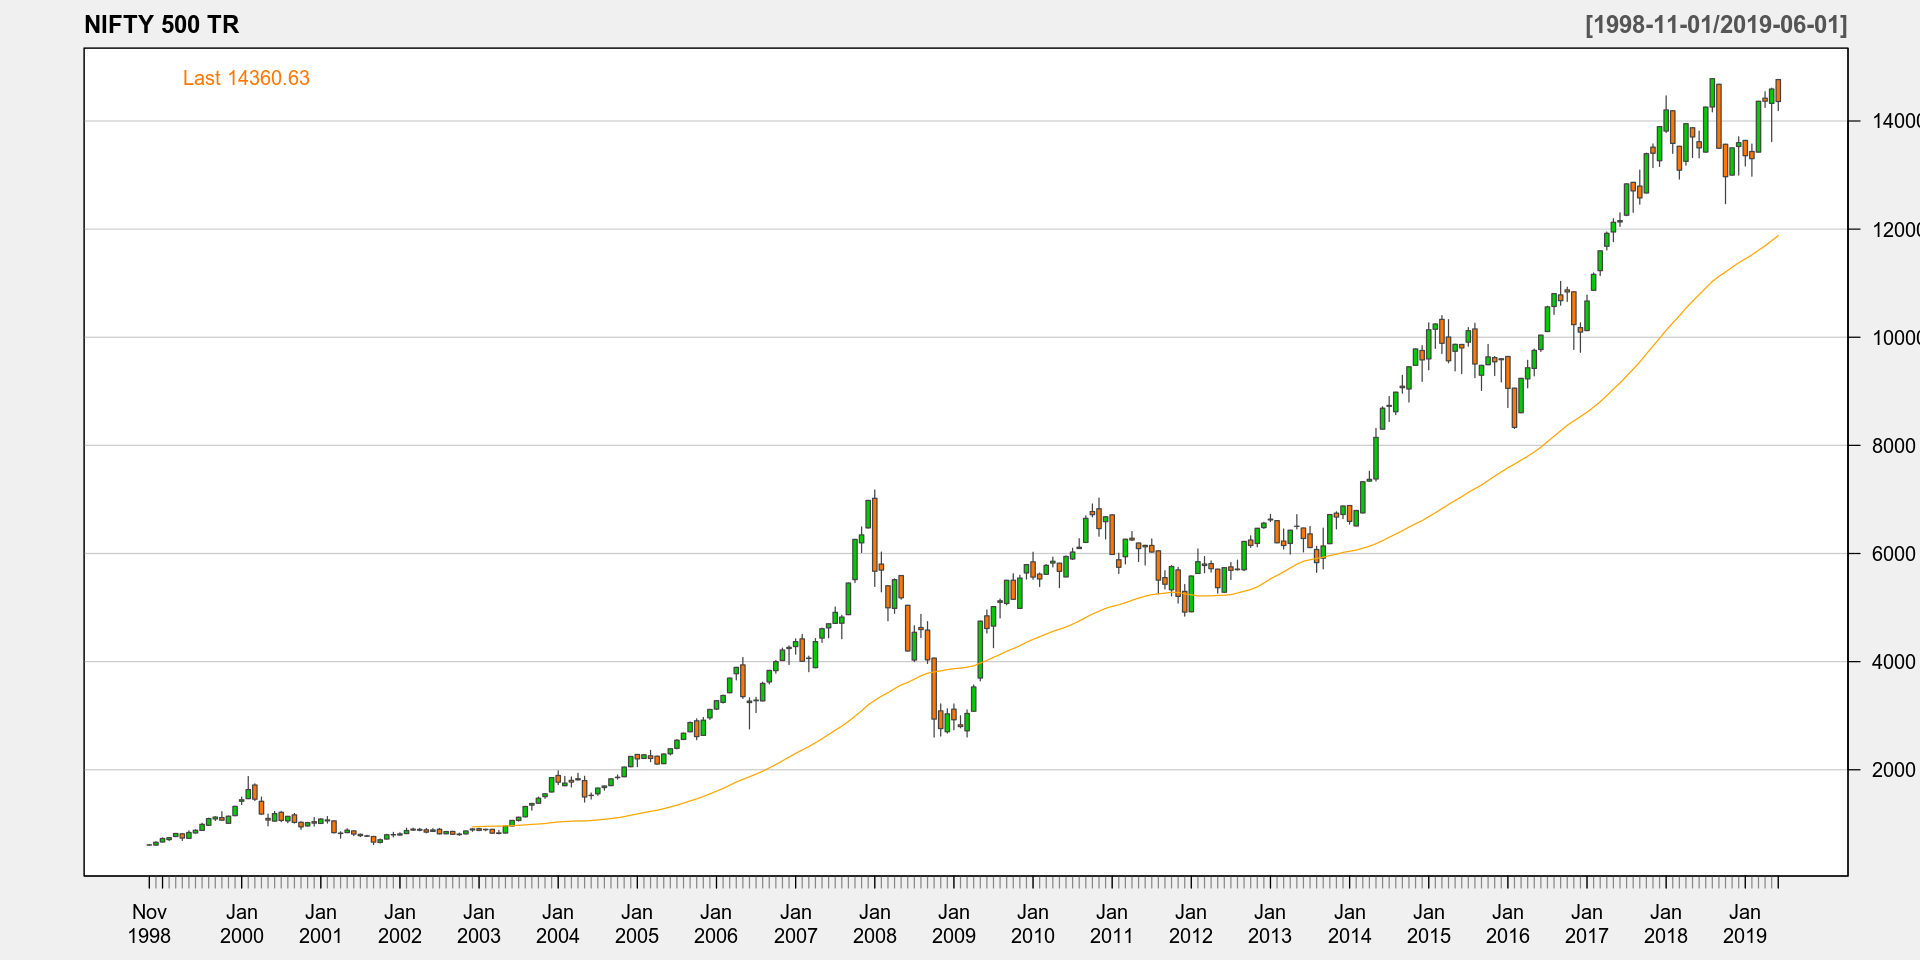

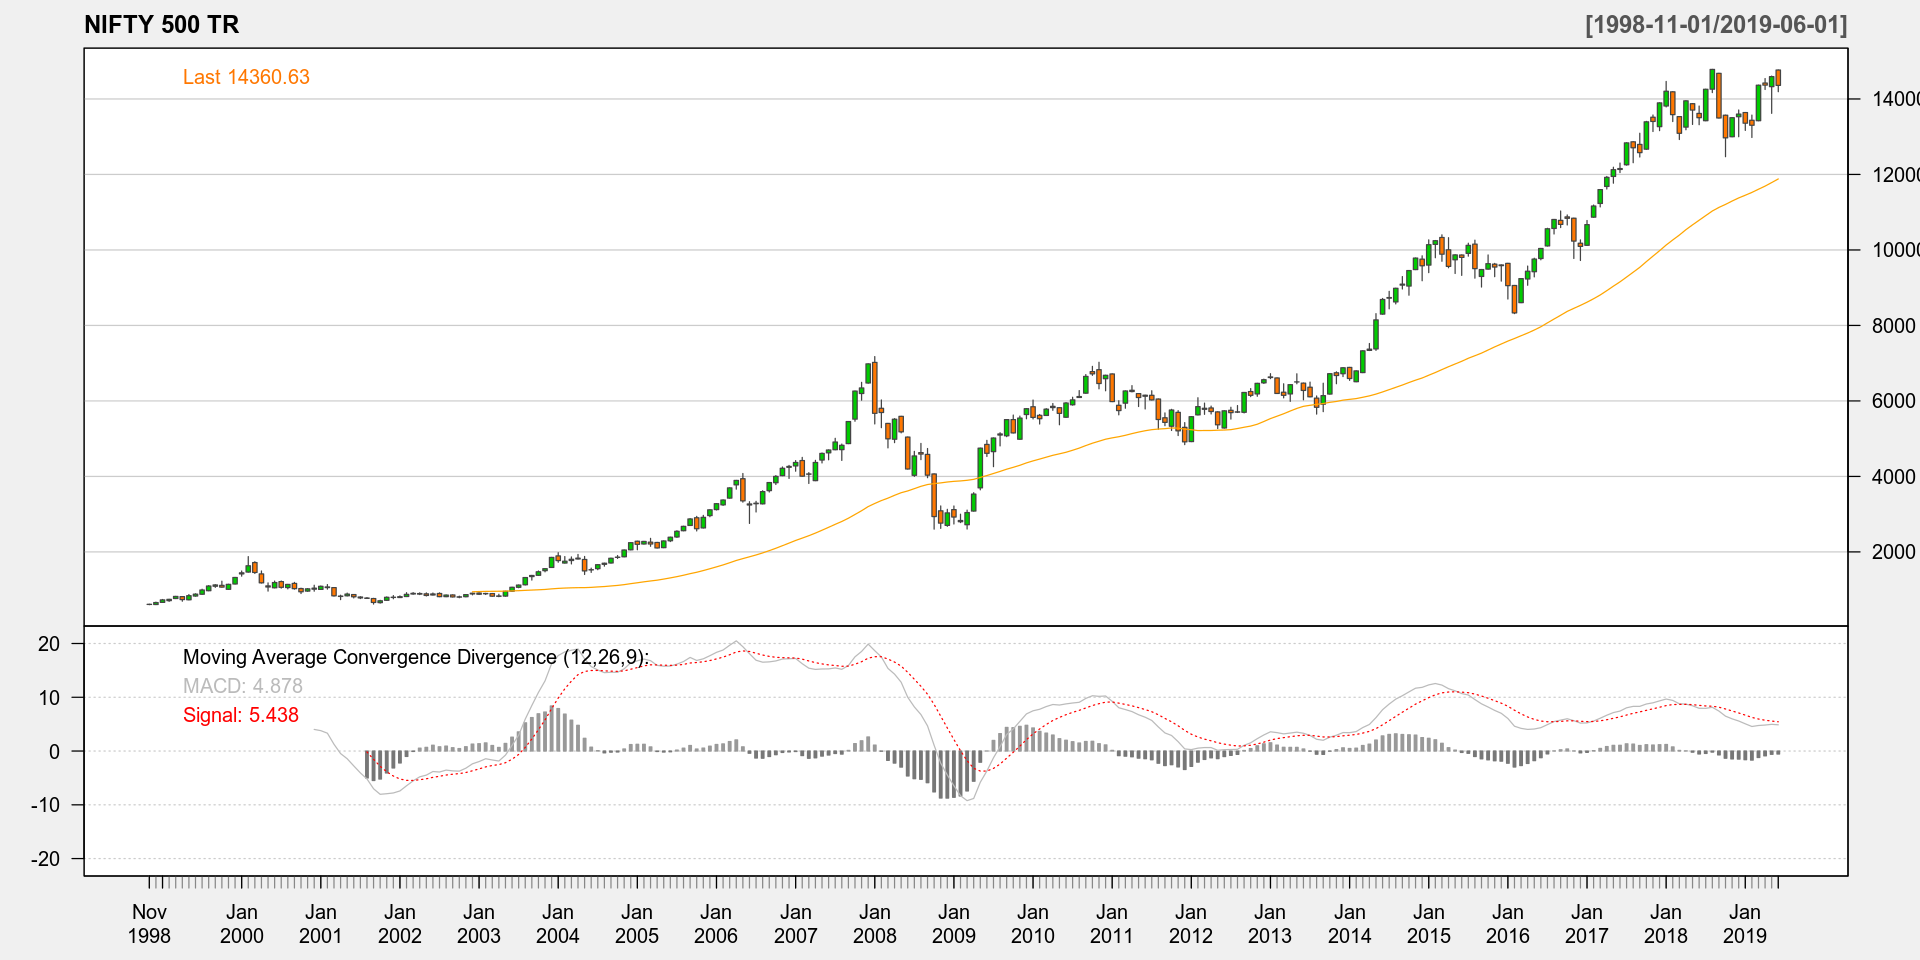

In [8]:
chartSeries(tail(monthlyTr, 1000), theme = 'white', name = indexName)
addSMA(50, col='orange')
addMACD()

#### ... and if you want only one chart:

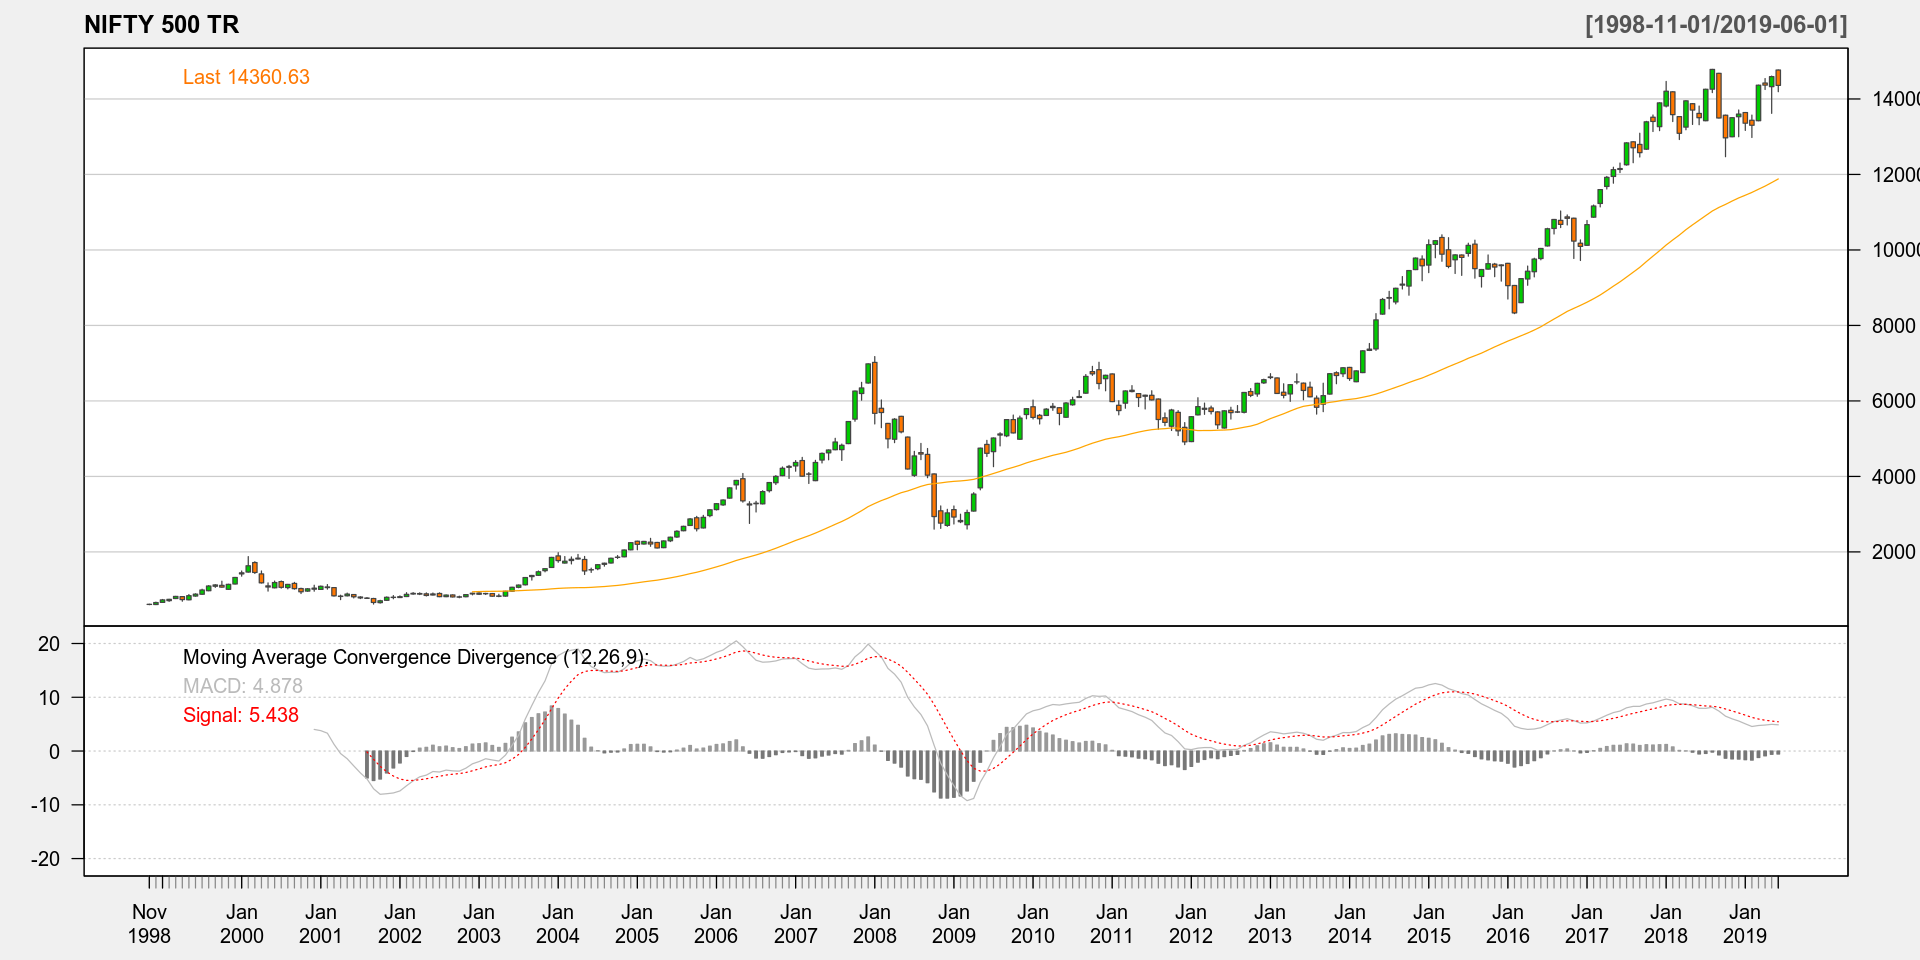

In [9]:
chartSeries(tail(monthlyTr, 1000), theme = 'white', name = indexName,
           TA=list("addSMA(50, col='orange')",
                  "addMACD()"))